In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight

mixed_precision.set_global_policy("mixed_float16")

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# -----------------------------
# PARAMETERS
# -----------------------------
BATCH_SIZE = 16
IMG_SIZE = (256, 256)         
NUM_CLASSES = 4
TRAIN_DIR = "./archive/brisc2025/classification_task/train"
TEST_DIR  = "./archive/brisc2025/classification_task/test"
VAL_SPLIT = 0.20
STAGE1_EPOCHS = 12
STAGE2_EPOCHS = 30
FINAL_MODEL_PATH = "ResNet101_BRISC.keras"

# -----------------------------
# DATA GENERATORS (same style as tuned model)
# -----------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=12,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.10,
    zoom_range=[0.85, 1.25],
    brightness_range=[0.75, 1.25],
    channel_shift_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VAL_SPLIT
)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed=SEED
)

# -----------------------------
# CLASS WEIGHTS
# -----------------------------
train_labels = train_gen.classes
cw = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(cw))
print("Class Weights:", class_weights)

# -----------------------------
# MODEL: ResNet101
# -----------------------------
base = ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base.trainable = False  # Stage 1: freeze backbone

# -----------------------------
# CLASSIFIER HEAD
# -----------------------------
inputs = base.input
x = base.output
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
model = models.Model(inputs, outputs)
model.summary()

# -----------------------------
# STAGE 1 TRAINING (frozen backbone)
# -----------------------------
loss_stage1 = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
opt1 = Adam(learning_rate=3e-4)

model.compile(
    optimizer=opt1,
    loss=loss_stage1,
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks_stage1 = [
    EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', patience=3, factor=0.5, min_lr=1e-6),
    ModelCheckpoint("ResNet101_stage1_best.keras", monitor='val_auc', mode='max', save_best_only=True)
]

history_stage1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE1_EPOCHS,
    callbacks=callbacks_stage1,
    class_weight=class_weights
)

# -----------------------------
# STAGE 2: UNFREEZE TOP 40% BACKBONE
# -----------------------------
total_layers = len(base.layers)
unfreeze_from = int(total_layers * 0.60)   

print(f"Unfreezing from layer {unfreeze_from} / {total_layers}")

for layer in base.layers[:unfreeze_from]:
    layer.trainable = False
for layer in base.layers[unfreeze_from:]:
    layer.trainable = True

# STAGE 2 — no label smoothing (helps recall)
loss_stage2 = tf.keras.losses.CategoricalCrossentropy()
opt2 = Adam(learning_rate=3e-5)

model.compile(
    optimizer=opt2,
    loss=loss_stage2,
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_auc', mode='max', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', mode='max', patience=4, factor=0.5, min_lr=1e-7),
    ModelCheckpoint("ResNet101_stage2_best.keras", monitor='val_auc', mode='max', save_best_only=True)
]

history_stage2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=STAGE2_EPOCHS,
    callbacks=callbacks_stage2,
    class_weight=class_weights
)

# -----------------------------
# SAVE MODEL
# -----------------------------
model.save(FINAL_MODEL_PATH)
print(f"\nSaved ResNet101 model to {FINAL_MODEL_PATH}\n")


Found 3402 images belonging to 4 classes.
Found 849 images belonging to 4 classes.
Class Weights: {0: np.float64(1.0903846153846153), 1: np.float64(0.9408185840707964), 2: np.float64(1.171487603305785), 3: np.float64(0.8573588709677419)}
 47833088/171446536 ━━━━━━━━━━━━━━━━━━━━ 2:37 1us/step

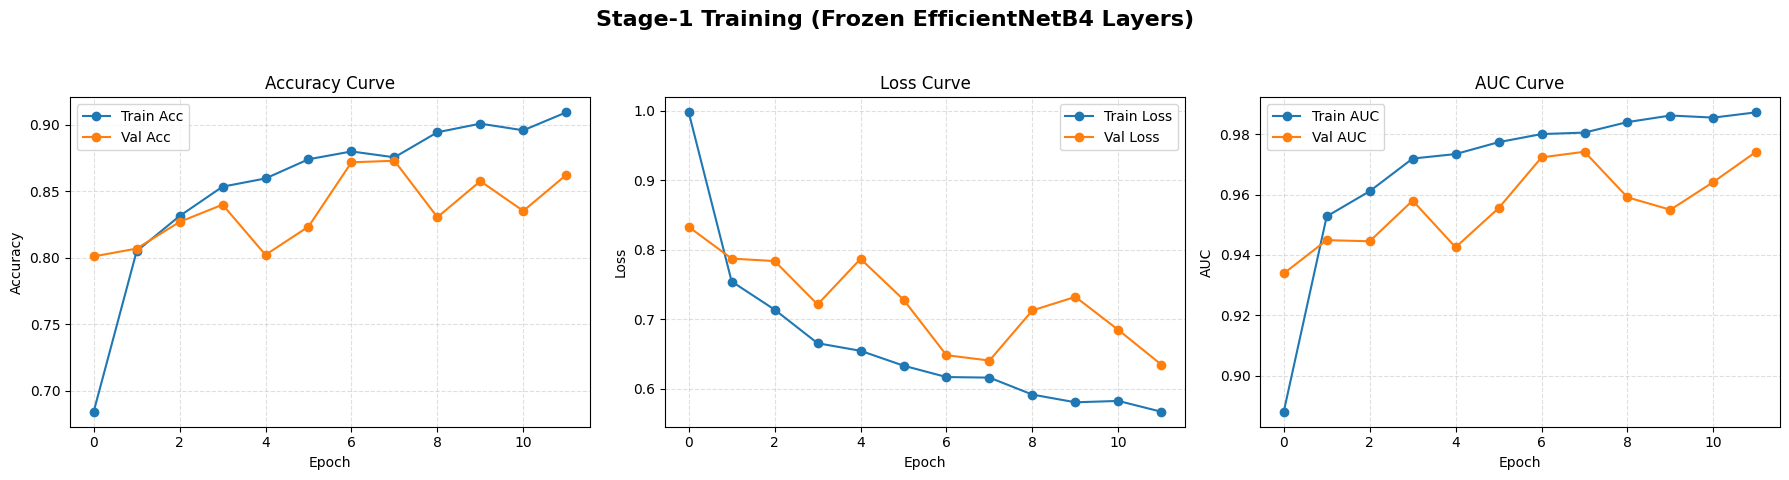

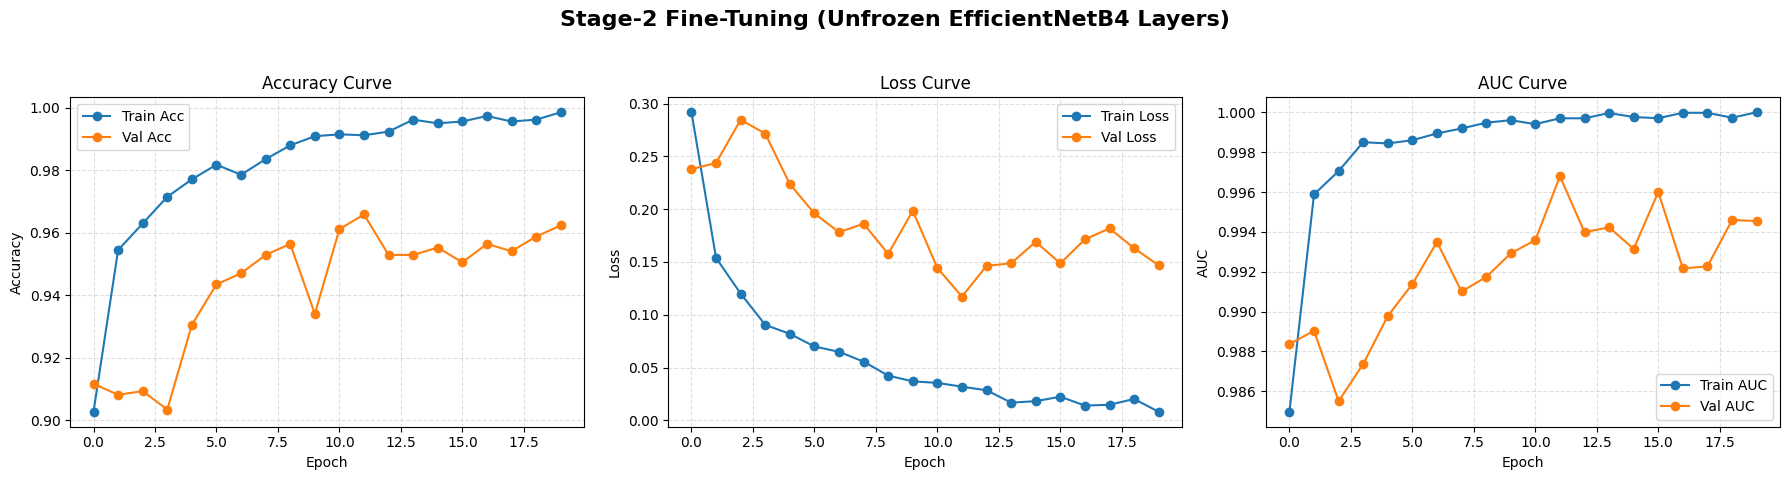

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize

# =====================================================================
# HISTORY PLOT (Accuracy, Loss, AUC)
# =====================================================================
def plot_history(history, title):
    plt.figure(figsize=(18,5))
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # ---------------------- Accuracy ----------------------
    plt.subplot(1,3,1)
    plt.plot(history.history['accuracy'], marker='o', label='Train Acc')
    plt.plot(history.history['val_accuracy'], marker='o', label='Val Acc')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()

    # ---------------------- Loss --------------------------
    plt.subplot(1,3,2)
    plt.plot(history.history['loss'], marker='o', label='Train Loss')
    plt.plot(history.history['val_loss'], marker='o', label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()

    # ---------------------- AUC ---------------------------
    if "auc" in history.history:
        plt.subplot(1,3,3)
        plt.plot(history.history['auc'], marker='o', label='Train AUC')
        plt.plot(history.history['val_auc'], marker='o', label='Val AUC')
        plt.title("AUC Curve")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.grid(True, linestyle='--', alpha=0.4)
        plt.legend()
    else:
        print("AUC metric not found in history keys.")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot Stage 1 and Stage 2 training curves
plot_history(history_stage1, "Stage-1 Training (Frozen EfficientNetB4 Layers)")
plot_history(history_stage2, "Stage-2 Fine-Tuning (Unfrozen EfficientNetB4 Layers)")

In [ ]:
# ===========================================================
# RECREATE TEST GENERATOR (required!)
# ===========================================================
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

# ===========================================================
# MODEL EVALUATION
# ===========================================================
print("\nRunning evaluation on TEST set...\n")

test_gen.reset()
y_prob = model.predict(test_gen, verbose=1)

y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# ===========================================================
# CONFUSION MATRIX
# ===========================================================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - EfficientNetB4")
plt.show()

# ===========================================================
# CLASSIFICATION REPORT
# ===========================================================
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===========================================================
# PER-CLASS AUC (One-vs-Rest)
# ===========================================================
try:
    y_true_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))
    aucs = {}

    for i, cname in enumerate(class_names):
        aucs[cname] = roc_auc_score(y_true_bin[:, i], y_prob[:, i])

    print("\nPer-class AUC scores:")
    for cname, auc_val in aucs.items():
        print(f"{cname}: {auc_val:.4f}")

except Exception as e:
    print("Could not compute per-class AUC:", e)
